In [1]:
import sys
import os
import numpy as np
import torch
from torchinfo import summary
import yaml
import sys
from timeit import default_timer
from utilities import *
from UFNO3d import UFNO3d

with open('config_UFNO.yml') as f:
    config = yaml.full_load(f)
cuda_id = "cuda:"+"0"
device = torch.device(cuda_id if torch.cuda.is_available() else "cpu")
item = 'UFNO3d_config'
config = config[item]
TRAIN_PATH = config['TRAIN_PATH']
VAL_PATH   = config['VAL_PATH']
TEST_PATH  = config['TEST_PATH']
save_mode  = config['save_mode']
save_step  = config['save_step']
n_out      = config['n_out'] # rhoxy, rhoyx
model_path = "../model/"+config['name']+ "_"+str(n_out) # save path and name of model
model_path_temp = "../temp_model/"+config['name']+"_"+ str(n_out)
log_path = "../log/"+config['name']+"_"+str(n_out)+'.log'
ntrain = config['ntrain']
nval = config['nval']
ntest  = config['ntest']
batch_size = config['batch_size']
learning_rate = config['learning_rate']
epochs = config['epochs']
step_size = config['step_size']
gamma = config['gamma']
modes1 = config['modes1']
modes2 = config['modes2']
width = config['width']
s_train = config['s_train']
r_train = config['r_train']
s_val = config['s_val']
r_val = config['r_val']
s_test = config['s_test']
r_test = config['r_test']
layer_sizes = [s_train[0]*s_train[1]] + config['layer_sizes']
act_fno   = config['act_fno']
init_func = config['init_func']    
patience = config['patience'] # if there is {patience} epoch that val_error is larger, early stop,
thre_epoch = config['thre_epoch']# condiser early stop after {thre_epoch} epochs
print_model_flag = config['print_model_flag'] # print model

key_map0 = ['rhoxy','rhoyx'] 
key_map = key_map0[:n_out] 
print(TRAIN_PATH)

# get training data 
reader = MatReader(TRAIN_PATH) 
x_train = reader.read_field('sig') 
x_train = x_train[:ntrain,::r_train[0],::r_train[1]][:,:s_train[0],:s_train[1]] 
y_train = torch.stack([reader.read_field(key_map[i])\
[:ntrain,::r_train[2],::r_train[3]][:,:s_train[2],:s_train[3]] for i in range(len(key_map))]).permute(1,2,3,0)
freq_base    = reader.read_field('freq')[0] 
obs_base     = reader.read_field('obs')[0] 
freq    = torch.log10(freq_base[::r_train[2]][:s_train[2]]) 
obs     = obs_base[::r_train[3]][:s_train[3]]/torch.max(obs_base) 
nSample = x_train.shape[0] 
nLoc = obs.shape[0]
nFreq = freq.shape[0]
freq = freq.view(nFreq, -1)
del reader

# dataset normalization  
x_normalizer = GaussianNormalizer(x_train)   
y_normalizer = GaussianNormalizer_out(y_train)  

# load network model 
model = UFNO3d(modes1, modes1, modes2, width, n_out, layer_sizes, init_func, act_fno).to(device)
model_path = sys.path[0] + "/../temp_model/UFNO3d_config_2_epoch_500.pkl"
print("model_path", model_path)
model.load_state_dict(torch.load(model_path))

# The input data defines in the predict function is un-normalized (the original input data)
# and the output data defines in the predict function is also un-normalized
def predict(x, freq=freq):

    x = x.unsqueeze(0).unsqueeze(3)
    x = x_normalizer.encode(x)
    freq = freq.to(device)
    x = x.to(device)
    with torch.no_grad():
        out = model(x,  freq)
        out = y_normalizer.decode(out)
    out = out.squeeze()

    return out.cpu().numpy()

../data/TrainDataSet.mat
model_path /home/em/weiyangliao/NeuralOperatorCode_20241101/code/../temp_model/UFNO3d_config_2_epoch_500.pkl


In [2]:
print(freq)

tensor([[ 3.0000],
        [ 2.2258],
        [ 1.4516],
        [ 0.6774],
        [-0.0968],
        [-0.8710],
        [-1.6452],
        [-2.4194]])


In [3]:
torch.__version__

'2.0.0+cu118'

In [4]:
torch.cuda.is_available()

True

# Error analysis of the whole dataset

- The whole error analysis (including all sites and receivers) of the training dataset

In [5]:
from numpy import linalg as LA
reader_train1 = MatReader(TRAIN_PATH)
x_train1 = reader_train1.read_field('sig')
y_train_rhoxy = reader_train1.read_field('rhoxy').numpy()
y_train_rhoyx = reader_train1.read_field('rhoyx').numpy()
nSample = x_train1.shape[0]

err_all = np.zeros((nSample, 3))
for i in range(nSample):

    xTrainNew = x_train1[i,:,:]
    result = predict(xTrainNew)
    rhoxy_predict = pow(10, result[:,:,0])
    rhoyx_predict = pow(10, result[:,:,1])

    data1 = y_train_rhoxy[i,::4,:]
    data2 = y_train_rhoyx[i,::4,:]
    data1 = pow(10, data1)
    data2 = pow(10, data2)

    rhoxy_predict_all = rhoxy_predict.flatten()
    rhoyx_predict_all = rhoyx_predict.flatten()

    y_train_rhoxy_all = data1.flatten()
    y_train_rhoyx_all = data2.flatten()
    
    diff1 = (rhoxy_predict_all - y_train_rhoxy_all)/y_train_rhoxy_all*100
    err1 = LA.norm(diff1, 2) / len(y_train_rhoxy_all) ** 0.5

    diff2 = (rhoyx_predict_all - y_train_rhoyx_all)/y_train_rhoyx_all*100
    err2 = LA.norm(diff2, 2) / len(y_train_rhoxy_all) ** 0.5

    diff = np.power(diff1, 2) + np.power(diff2, 2)
    err = np.sqrt(np.sum(diff)) / (2*len(diff)) ** 0.5
    
    err_all[i, 0] = err1
    err_all[i, 1] = err2
    err_all[i, 2] = err

In [6]:
err_data_new = err_all[:,2]
len(err_data_new[err_data_new>5].flatten())

433

In [7]:
# <5% error
nSample - len(err_data_new[err_data_new>5].flatten())

29567

In [8]:
print("error < 5%: ", (1-len(err_data_new[err_data_new>5].flatten())/nSample)*100, "%")

error < 5%:  98.55666666666667 %


In [9]:
# <10% error
nSample - len(err_data_new[err_data_new>10].flatten())

29988

In [10]:
print("error < 10%: ", (1-len(err_data_new[err_data_new>10].flatten())/nSample)*100, "%")

error < 10%:  99.96000000000001 %


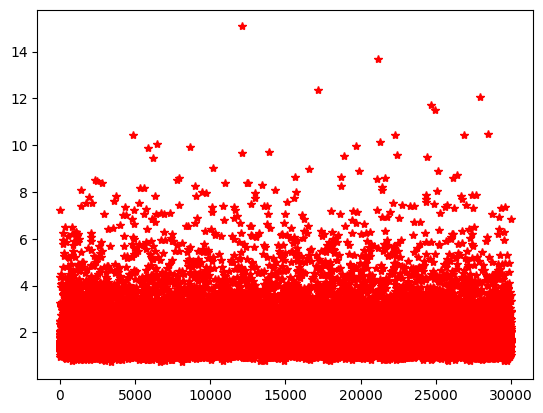

In [12]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.figure()
plt.plot(err_data_new, 'r*')

In [12]:
import time
from numpy import linalg as LA
reader_train1 = MatReader(TRAIN_PATH)
x_train1 = reader_train1.read_field('sig')
y_train_rhoxy = reader_train1.read_field('rhoxy').numpy()
y_train_rhoyx = reader_train1.read_field('rhoyx').numpy()
nSample = 1000

start_time = time.time() 
err_all = np.zeros((nSample, 3))
for i in range(nSample):
    xTrainNew = x_train1[i,:,:]
    result = predict(xTrainNew)
end_time = time.time()    
run_time = end_time - start_time   
print("The run time of one single prediction is : %.06f seconds" %(run_time/nSample))

The run time of one single prediction is : 0.008198 seconds


- $R^2$ and $RMSE$ statistics of the training dataset

In [13]:
freq_base, freq_base.shape

(tensor([1.0000e+03, 6.4040e+02, 4.1011e+02, 2.6264e+02, 1.6819e+02, 1.0771e+02,
         6.8978e+01, 4.4173e+01, 2.8289e+01, 1.8116e+01, 1.1602e+01, 7.4296e+00,
         4.7579e+00, 3.0470e+00, 1.9513e+00, 1.2496e+00, 8.0025e-01, 5.1248e-01,
         3.2819e-01, 2.1017e-01, 1.3460e-01, 8.6195e-02, 5.5200e-02, 3.5350e-02,
         2.2638e-02, 1.4497e-02, 9.2841e-03, 5.9456e-03, 3.8075e-03, 2.4384e-03,
         1.5615e-03, 1.0000e-03]),
 torch.Size([32]))

In [14]:
freq1 = torch.log10(freq_base[0:-1:4])
print(freq1)
freq2 = torch.log10(freq_base[1:-1:4])
print(freq2)
freq3 = torch.log10(freq_base[2:-1:4])
print(freq3)
freq4 = torch.log10(freq_base[3:freq_base.shape[0]+1:4])
print(freq4)

tensor([ 3.0000,  2.2258,  1.4516,  0.6774, -0.0968, -0.8710, -1.6452, -2.4194])
tensor([ 2.8065,  2.0323,  1.2581,  0.4839, -0.2903, -1.0645, -1.8387, -2.6129])
tensor([ 2.6129,  1.8387,  1.0645,  0.2903, -0.4839, -1.2581, -2.0323, -2.8065])
tensor([ 2.4194,  1.6452,  0.8710,  0.0968, -0.6774, -1.4516, -2.2258, -3.0000])


In [15]:
def predict1(x, freq=freq1):

    x = x.unsqueeze(0).unsqueeze(3)
    x = x_normalizer.encode(x)
    x = x.to(device)
    with torch.no_grad():
        out = model(x,  freq)
        out = y_normalizer.decode(out)
    out = out.squeeze()

    return out.cpu().numpy()

def predict2(x, freq=freq2):

    x = x.unsqueeze(0).unsqueeze(3)
    x = x_normalizer.encode(x)
    x = x.to(device)
    with torch.no_grad():
        out = model(x,  freq)
        out = y_normalizer.decode(out)
    out = out.squeeze()

    return out.cpu().numpy()

def predict3(x, freq=freq3):  
    
        x = x.unsqueeze(0).unsqueeze(3)
        x = x_normalizer.encode(x)
        x = x.to(device)
        with torch.no_grad():
            out = model(x,  freq)
            out = y_normalizer.decode(out)
        out = out.squeeze()
    
        return out.cpu().numpy()

def predict4(x, freq=freq4):
         
        x = x.unsqueeze(0).unsqueeze(3)
        x = x_normalizer.encode(x)
        x = x.to(device)
        with torch.no_grad():
            out = model(x,  freq)
            out = y_normalizer.decode(out)
        out = out.squeeze()
    
        return out.cpu().numpy()

In [16]:
from numpy import linalg as LA
reader_train1 = MatReader(TRAIN_PATH)
x_train1 = reader_train1.read_field('sig')
y_train_rhoxy = reader_train1.read_field('rhoxy').numpy()
y_train_rhoyx = reader_train1.read_field('rhoyx').numpy()
nSample = x_train1.shape[0]

(nTol, nFreq, nSite) = y_train_rhoxy.shape
nnFreq = np.int64(nFreq/4)

err_all = np.zeros((nSample, 3))
predict_data1 = np.zeros((nSample, nnFreq, nSite, 2))
real_data1 = np.zeros((nSample, nnFreq, nSite, 2))
real_data1[:,:,:,0] = pow(10, y_train_rhoxy[:nSample,::4,:])
real_data1[:,:,:,1] = pow(10, y_train_rhoyx[:nSample,::4,:])

predict_data2 = np.zeros((nSample, nnFreq, nSite, 2))
real_data2 = np.zeros((nSample, nnFreq, nSite, 2))
real_data2[:,:,:,0] = pow(10, y_train_rhoxy[:nSample,1:-1:4,:])
real_data2[:,:,:,1] = pow(10, y_train_rhoyx[:nSample,1:-1:4,:])

predict_data3 = np.zeros((nSample, nnFreq, nSite, 2))
real_data3 = np.zeros((nSample, nnFreq, nSite, 2))
real_data3[:,:,:,0] = pow(10, y_train_rhoxy[:nSample,2:-1:4,:])
real_data3[:,:,:,1] = pow(10, y_train_rhoyx[:nSample,2:-1:4,:])

predict_data4 = np.zeros((nSample, nnFreq, nSite, 2))
real_data4 = np.zeros((nSample, nnFreq, nSite, 2))
real_data4[:,:,:,0] = pow(10, y_train_rhoxy[:nSample,3:nFreq+1:4,:])
real_data4[:,:,:,1] = pow(10, y_train_rhoyx[:nSample,3:nFreq+1:4,:])

for i in range(nSample):

    xTrainNew = x_train1[i,:,:]
    
    result = predict1(xTrainNew)
    rhoxy_predict = pow(10, result[:,:,0])
    rhoyx_predict = pow(10, result[:,:,1])
    predict_data1[i,:,:,0] = rhoxy_predict
    predict_data1[i,:,:,1] = rhoyx_predict

    result = predict2(xTrainNew)
    rhoxy_predict = pow(10, result[:,:,0])
    rhoyx_predict = pow(10, result[:,:,1])
    predict_data2[i,:,:,0] = rhoxy_predict
    predict_data2[i,:,:,1] = rhoyx_predict

    result = predict3(xTrainNew)
    rhoxy_predict = pow(10, result[:,:,0])
    rhoyx_predict = pow(10, result[:,:,1])
    predict_data3[i,:,:,0] = rhoxy_predict
    predict_data3[i,:,:,1] = rhoyx_predict

    result = predict4(xTrainNew)
    rhoxy_predict = pow(10, result[:,:,0])
    rhoyx_predict = pow(10, result[:,:,1])
    predict_data4[i,:,:,0] = rhoxy_predict
    predict_data4[i,:,:,1] = rhoyx_predict

In [17]:
real_data_reshape1 = real_data1.reshape(nSample, nnFreq, -1)
predict_data_reshape1 = predict_data1.reshape(nSample, nnFreq, -1)
real_data_reshape2 = real_data2.reshape(nSample, nnFreq, -1)
predict_data_reshape2 = predict_data2.reshape(nSample, nnFreq, -1)
real_data_reshape3 = real_data3.reshape(nSample, nnFreq, -1)
predict_data_reshape3 = predict_data3.reshape(nSample, nnFreq, -1)
real_data_reshape4 = real_data4.reshape(nSample, nnFreq, -1)
predict_data_reshape4 = predict_data4.reshape(nSample, nnFreq, -1)

In [18]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
 
r2_1 = np.zeros(nnFreq)
r2_2 = np.zeros(nnFreq)
r2_3 = np.zeros(nnFreq)
r2_4 = np.zeros(nnFreq)

rmse_1 = np.zeros(nnFreq)
rmse_2 = np.zeros(nnFreq)
rmse_3 = np.zeros(nnFreq)
rmse_4 = np.zeros(nnFreq)

mae_1 = np.zeros(nnFreq)
mae_2 = np.zeros(nnFreq)
mae_3 = np.zeros(nnFreq)
mae_4 = np.zeros(nnFreq)

r1 = np.log10(real_data_reshape1)
p1 = np.log10(predict_data_reshape1)
r2 = np.log10(real_data_reshape2)
p2 = np.log10(predict_data_reshape2)
r3 = np.log10(real_data_reshape3)
p3 = np.log10(predict_data_reshape3)
r4 = np.log10(real_data_reshape4)
p4 = np.log10(predict_data_reshape4)

for i in range(nnFreq):
    r2_1[i] = r2_score(r1[:,i,:].flatten(), p1[:,i,:].flatten())
    r2_2[i] = r2_score(r2[:,i,:].flatten(), p2[:,i,:].flatten())
    r2_3[i] = r2_score(r3[:,i,:].flatten(), p3[:,i,:].flatten())
    r2_4[i] = r2_score(r4[:,i,:].flatten(), p4[:,i,:].flatten())

    rmse_1[i] = mean_squared_error(r1[:,i,:].flatten(), p1[:,i,:].flatten(), squared=False)
    rmse_2[i] = mean_squared_error(r2[:,i,:].flatten(), p2[:,i,:].flatten(), squared=False)
    rmse_3[i] = mean_squared_error(r3[:,i,:].flatten(), p3[:,i,:].flatten(), squared=False)
    rmse_4[i] = mean_squared_error(r4[:,i,:].flatten(), p4[:,i,:].flatten(), squared=False)

    mae_1[i] = mean_absolute_error(r1[:,i,:].flatten(), p1[:,i,:].flatten())
    mae_2[i] = mean_absolute_error(r2[:,i,:].flatten(), p2[:,i,:].flatten())
    mae_3[i] = mean_absolute_error(r3[:,i,:].flatten(), p3[:,i,:].flatten())
    mae_4[i] = mean_absolute_error(r4[:,i,:].flatten(), p4[:,i,:].flatten())

print("\nr2=================")
print(r2_1)
print(r2_2)
print(r2_3)
print(r2_4)

print("\nrmse=================")
print(rmse_1)
print(rmse_2)
print(rmse_3)
print(rmse_4)

print("\nmae=================")
print(mae_1)
print(mae_2)
print(mae_3)
print(mae_4)


r2=================
[0.99994541 0.99994272 0.99992865 0.99988687 0.99982989 0.99981056
 0.99982999 0.99983441]
[0.99797932 0.99658966 0.9919805  0.9854336  0.98193615 0.97944365
 0.98144152 0.98914425]
[0.99222267 0.98538835 0.96478719 0.94035878 0.93236656 0.92316343
 0.93254873 0.95975434]
[0.9830598  0.96467956 0.91425631 0.86664101 0.86178766 0.84020858
 0.8619738  0.91627544]

rmse=================
[0.00677153 0.00656411 0.00666231 0.00756554 0.00907289 0.01055131
 0.01159162 0.01318919]
[0.04079086 0.04962685 0.06870899 0.08438956 0.0949103  0.11380256
 0.1257954  0.11006888]
[0.07903854 0.1004019  0.1400763  0.16904327 0.18777654 0.22827046
 0.24878879 0.21786124]
[0.11490661 0.15224509 0.21301075 0.25231001 0.27602894 0.34196149
 0.36853331 0.32215703]

mae=================
[0.00483818 0.00470769 0.00480591 0.00535104 0.00625467 0.00704719
 0.00766513 0.00875607]
[0.02976242 0.03916136 0.05740994 0.0713063  0.07759912 0.0883633
 0.09738008 0.08590785]
[0.05806338 0.08030079 0.

[0.99994541 0.99797932 0.99222267 0.9830598  0.99994272 0.99658966
 0.98538835 0.96467956 0.99992865 0.9919805  0.96478719 0.91425631
 0.99988687 0.9854336  0.94035878 0.86664101 0.99982989 0.98193615
 0.93236656 0.86178766 0.99981056 0.97944365 0.92316343 0.84020858
 0.99982999 0.98144152 0.93254873 0.8619738  0.99983441 0.98914425
 0.95975434 0.91627544]
[0.00677153 0.04079086 0.07903854 0.11490661 0.00656411 0.04962685
 0.1004019  0.15224509 0.00666231 0.06870899 0.1400763  0.21301075
 0.00756554 0.08438956 0.16904327 0.25231001 0.00907289 0.0949103
 0.18777654 0.27602894 0.01055131 0.11380256 0.22827046 0.34196149
 0.01159162 0.1257954  0.24878879 0.36853331 0.01318919 0.11006888
 0.21786124 0.32215703]
[0.00483818 0.02976242 0.05806338 0.08559117 0.00470769 0.03916136
 0.08030079 0.12323331 0.00480591 0.05740994 0.11773684 0.17978947
 0.00535104 0.0713063  0.14288924 0.21320748 0.00625467 0.07759912
 0.15310155 0.22410986 0.00704719 0.0883633  0.17680972 0.26454218
 0.00766513 0.0

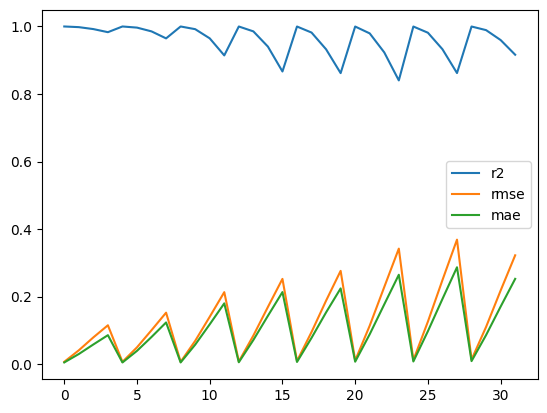

In [19]:
r2 = np.zeros(nFreq)
for i in range(nnFreq):
    r2[4*i] = r2_1[i]
    r2[4*i+1] = r2_2[i]
    r2[4*i+2] = r2_3[i]
    r2[4*i+3] = r2_4[i]

rmse= np.zeros(nFreq)
for i in range(nnFreq):
    rmse[4*i] = rmse_1[i]
    rmse[4*i+1] = rmse_2[i]
    rmse[4*i+2] = rmse_3[i]
    rmse[4*i+3] = rmse_4[i]

mae = np.zeros(nFreq)
for i in range(nnFreq):
    mae[4*i] = mae_1[i]
    mae[4*i+1] = mae_2[i]
    mae[4*i+2] = mae_3[i]
    mae[4*i+3] = mae_4[i]

print(r2)
print(rmse)
print(mae)

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.figure()
plt.plot(r2)
plt.plot(rmse)
plt.plot(mae)
plt.legend(['r2', 'rmse', 'mae'], )

- $R^2$, $RMSE$ and $MAE$ statistics of the test dataset

In [20]:
from numpy import linalg as LA
read_test1 = MatReader(TEST_PATH) # test dataset
x_test1 = read_test1.read_field('sig')
y_test_rhoxy = read_test1.read_field('rhoxy').numpy()
y_test_rhoyx = read_test1.read_field('rhoyx').numpy()
nSample = x_test1.shape[0]

(nTol, nFreq, nSite) = y_test_rhoxy.shape
nnFreq = np.int64(nFreq/4)

err_all = np.zeros((nSample, 3))
predict_data1 = np.zeros((nSample, nnFreq, nSite, 2))
real_data1 = np.zeros((nSample, nnFreq, nSite, 2))
real_data1[:,:,:,0] = pow(10, y_test_rhoxy[:nSample,::4,:])
real_data1[:,:,:,1] = pow(10, y_test_rhoyx[:nSample,::4,:])

predict_data2 = np.zeros((nSample, nnFreq, nSite, 2))
real_data2 = np.zeros((nSample, nnFreq, nSite, 2))
real_data2[:,:,:,0] = pow(10, y_test_rhoxy[:nSample,1:-1:4,:])
real_data2[:,:,:,1] = pow(10, y_test_rhoyx[:nSample,1:-1:4,:])

predict_data3 = np.zeros((nSample, nnFreq, nSite, 2))
real_data3 = np.zeros((nSample, nnFreq, nSite, 2))
real_data3[:,:,:,0] = pow(10, y_test_rhoxy[:nSample,2:-1:4,:])
real_data3[:,:,:,1] = pow(10, y_test_rhoyx[:nSample,2:-1:4,:])

predict_data4 = np.zeros((nSample, nnFreq, nSite, 2))
real_data4 = np.zeros((nSample, nnFreq, nSite, 2))
real_data4[:,:,:,0] = pow(10, y_test_rhoxy[:nSample,3:nFreq+1:4,:])
real_data4[:,:,:,1] = pow(10, y_test_rhoyx[:nSample,3:nFreq+1:4,:])

for i in range(nSample):

    xTestNew = x_test1[i,:,:]
    
    result = predict1(xTestNew)
    rhoxy_predict = pow(10, result[:,:,0])
    rhoyx_predict = pow(10, result[:,:,1])
    predict_data1[i,:,:,0] = rhoxy_predict
    predict_data1[i,:,:,1] = rhoyx_predict

    result = predict2(xTestNew)
    rhoxy_predict = pow(10, result[:,:,0])
    rhoyx_predict = pow(10, result[:,:,1])
    predict_data2[i,:,:,0] = rhoxy_predict
    predict_data2[i,:,:,1] = rhoyx_predict

    result = predict3(xTestNew)
    rhoxy_predict = pow(10, result[:,:,0])
    rhoyx_predict = pow(10, result[:,:,1])
    predict_data3[i,:,:,0] = rhoxy_predict
    predict_data3[i,:,:,1] = rhoyx_predict

    result = predict4(xTestNew)
    rhoxy_predict = pow(10, result[:,:,0])
    rhoyx_predict = pow(10, result[:,:,1])
    predict_data4[i,:,:,0] = rhoxy_predict
    predict_data4[i,:,:,1] = rhoyx_predict

In [21]:
real_data_reshape1 = real_data1.reshape(nSample, nnFreq, -1)
predict_data_reshape1 = predict_data1.reshape(nSample, nnFreq, -1)
real_data_reshape2 = real_data2.reshape(nSample, nnFreq, -1)
predict_data_reshape2 = predict_data2.reshape(nSample, nnFreq, -1)
real_data_reshape3 = real_data3.reshape(nSample, nnFreq, -1)
predict_data_reshape3 = predict_data3.reshape(nSample, nnFreq, -1)
real_data_reshape4 = real_data4.reshape(nSample, nnFreq, -1)
predict_data_reshape4 = predict_data4.reshape(nSample, nnFreq, -1)

In [22]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
 
r2_1 = np.zeros(nnFreq)
r2_2 = np.zeros(nnFreq)
r2_3 = np.zeros(nnFreq)
r2_4 = np.zeros(nnFreq)

rmse_1 = np.zeros(nnFreq)
rmse_2 = np.zeros(nnFreq)
rmse_3 = np.zeros(nnFreq)
rmse_4 = np.zeros(nnFreq)

mae_1 = np.zeros(nnFreq)
mae_2 = np.zeros(nnFreq)
mae_3 = np.zeros(nnFreq)
mae_4 = np.zeros(nnFreq)

r1 = np.log10(real_data_reshape1)
p1 = np.log10(predict_data_reshape1)
r2 = np.log10(real_data_reshape2)
p2 = np.log10(predict_data_reshape2)
r3 = np.log10(real_data_reshape3)
p3 = np.log10(predict_data_reshape3)
r4 = np.log10(real_data_reshape4)
p4 = np.log10(predict_data_reshape4)

for i in range(nnFreq):
    r2_1[i] = r2_score(r1[:,i,:].flatten(), p1[:,i,:].flatten())
    r2_2[i] = r2_score(r2[:,i,:].flatten(), p2[:,i,:].flatten())
    r2_3[i] = r2_score(r3[:,i,:].flatten(), p3[:,i,:].flatten())
    r2_4[i] = r2_score(r4[:,i,:].flatten(), p4[:,i,:].flatten())

    rmse_1[i] = mean_squared_error(r1[:,i,:].flatten(), p1[:,i,:].flatten(), squared=False)
    rmse_2[i] = mean_squared_error(r2[:,i,:].flatten(), p2[:,i,:].flatten(), squared=False)
    rmse_3[i] = mean_squared_error(r3[:,i,:].flatten(), p3[:,i,:].flatten(), squared=False)
    rmse_4[i] = mean_squared_error(r4[:,i,:].flatten(), p4[:,i,:].flatten(), squared=False)

    mae_1[i] = mean_absolute_error(r1[:,i,:].flatten(), p1[:,i,:].flatten())
    mae_2[i] = mean_absolute_error(r2[:,i,:].flatten(), p2[:,i,:].flatten())
    mae_3[i] = mean_absolute_error(r3[:,i,:].flatten(), p3[:,i,:].flatten())
    mae_4[i] = mean_absolute_error(r4[:,i,:].flatten(), p4[:,i,:].flatten())

print("\nr2=================")
print(r2_1)
print(r2_2)
print(r2_3)
print(r2_4)

print("\nrmse=================")
print(rmse_1)
print(rmse_2)
print(rmse_3)
print(rmse_4)

print("\nmae=================")
print(mae_1)
print(mae_2)
print(mae_3)
print(mae_4)


r2=================
[0.99994234 0.99993769 0.99991313 0.9998451  0.99972679 0.9996382
 0.99960554 0.99955656]
[0.99798254 0.99648212 0.99163719 0.98520849 0.98200824 0.9789228
 0.9809122  0.98878119]
[0.99223537 0.98485411 0.96339895 0.93985472 0.93293956 0.9216106
 0.93123421 0.95912237]
[0.98305266 0.96318806 0.91119597 0.86625018 0.86288659 0.83700143
 0.85957946 0.91517746]

rmse=================
[0.00695034 0.00681579 0.00728868 0.00877432 0.01146419 0.01459778
 0.01769811 0.02164134]
[0.04067879 0.05012832 0.06951294 0.08436691 0.09457954 0.11539956
 0.12790179 0.11218462]
[0.07876322 0.10155414 0.14144173 0.16865891 0.18692243 0.23096088
 0.25187305 0.22009903]
[0.11452851 0.15424582 0.21473377 0.25149066 0.27508904 0.34608264
 0.37272602 0.32498057]

mae=================
[0.00502212 0.00494204 0.00523266 0.0060983  0.00774886 0.00945245
 0.01118982 0.01373862]
[0.0296713  0.0396774  0.05817869 0.07122298 0.07742418 0.09002592
 0.09949616 0.08835067]
[0.05785674 0.08140003 0.11

[0.99994234 0.99798254 0.99223537 0.98305266 0.99993769 0.99648212
 0.98485411 0.96318806 0.99991313 0.99163719 0.96339895 0.91119597
 0.9998451  0.98520849 0.93985472 0.86625018 0.99972679 0.98200824
 0.93293956 0.86288659 0.9996382  0.9789228  0.9216106  0.83700143
 0.99960554 0.9809122  0.93123421 0.85957946 0.99955656 0.98878119
 0.95912237 0.91517746]
[0.00695034 0.04067879 0.07876322 0.11452851 0.00681579 0.05012832
 0.10155414 0.15424582 0.00728868 0.06951294 0.14144173 0.21473377
 0.00877432 0.08436691 0.16865891 0.25149066 0.01146419 0.09457954
 0.18692243 0.27508904 0.01459778 0.11539956 0.23096088 0.34608264
 0.01769811 0.12790179 0.25187305 0.37272602 0.02164134 0.11218462
 0.22009903 0.32498057]
[0.00502212 0.0296713  0.05785674 0.08534423 0.00494204 0.0396774
 0.08140003 0.12501157 0.00523266 0.05817869 0.1191272  0.18162232
 0.0060983  0.07122298 0.14247787 0.21252103 0.00774886 0.07742418
 0.15266665 0.22356915 0.00945245 0.09002592 0.17956852 0.26863377
 0.01118982 0.0

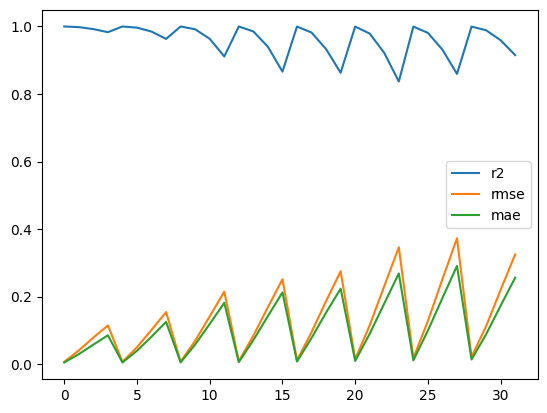

In [23]:
r2 = np.zeros(nFreq)
for i in range(nnFreq):
    r2[4*i] = r2_1[i]
    r2[4*i+1] = r2_2[i]
    r2[4*i+2] = r2_3[i]
    r2[4*i+3] = r2_4[i]

rmse= np.zeros(nFreq)
for i in range(nnFreq):
    rmse[4*i] = rmse_1[i]
    rmse[4*i+1] = rmse_2[i]
    rmse[4*i+2] = rmse_3[i]
    rmse[4*i+3] = rmse_4[i]

mae = np.zeros(nFreq)
for i in range(nnFreq):
    mae[4*i] = mae_1[i]
    mae[4*i+1] = mae_2[i]
    mae[4*i+2] = mae_3[i]
    mae[4*i+3] = mae_4[i]

print(r2)
print(rmse)
print(mae)

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.figure()
plt.plot(r2)
plt.plot(rmse)
plt.plot(mae)
plt.legend(['r2', 'rmse', 'mae'], )

- The No. 502 sample of the test dataset

In [24]:
from numpy import linalg as LA
reader_test1 = MatReader(TEST_PATH)
x_test1 = reader_test1.read_field('sig')
y_test_rhoxy = reader_test1.read_field('rhoxy').numpy()
y_test_rhoyx = reader_test1.read_field('rhoyx').numpy()

err_single = np.zeros((3))

# select sample
i = 501

xtestNew = x_test1[i,:,:]
result = predict(xtestNew)
rhoxy_predict = pow(10, result[:,:,0])
rhoyx_predict = pow(10, result[:,:,1])

data1 = y_test_rhoxy[i,::4,:]
data2 = y_test_rhoyx[i,::4,:]
data1 = pow(10, data1)
data2 = pow(10, data2)

rhoxy_predict_all = rhoxy_predict.flatten()
rhoyx_predict_all = rhoyx_predict.flatten()

y_test_rhoxy_all = data1.flatten()
y_test_rhoyx_all = data2.flatten()
    
diff1 = (rhoxy_predict_all - y_test_rhoxy_all)/y_test_rhoxy_all*100
# print(type(diff1))
err1 = LA.norm(diff1, 2) / len(y_test_rhoxy_all) ** 0.5

diff2 = (rhoyx_predict_all - y_test_rhoyx_all)/y_test_rhoyx_all*100
err2 = LA.norm(diff2, 2) / len(y_test_rhoxy_all) ** 0.5
# print(err1, err2)

diff = np.power(diff1, 2) + np.power(diff2, 2)
err = np.sqrt(np.sum(diff)) / (2*len(diff)) ** 0.5
    
err_single[0] = err1
err_single[1] = err2
err_single[2] = err

UFNO3d_rhoxy_predict = rhoxy_predict
UFNO3d_rhoyx_predict = rhoyx_predict

UFNO3d_rhoxy_real = data1
UFNO3d_rhoyx_real = data2

print(err_single)

[1.36269255 2.80418426 2.20458386]


- The No. $2501$ sample of the test dataset

In [25]:
from numpy import linalg as LA
reader_test1 = MatReader(TEST_PATH)
x_test1 = reader_test1.read_field('sig')
y_test_rhoxy = reader_test1.read_field('rhoxy').numpy()
y_test_rhoyx = reader_test1.read_field('rhoyx').numpy()

err_single = np.zeros((3))

# select sample
i = 2500

xtestNew = x_test1[i,:,:]
result = predict(xtestNew)
rhoxy_predict = pow(10, result[:,:,0])
rhoyx_predict = pow(10, result[:,:,1])

data1 = y_test_rhoxy[i,::4,:]
data2 = y_test_rhoyx[i,::4,:]
data1 = pow(10, data1)
data2 = pow(10, data2)

rhoxy_predict_all = rhoxy_predict.flatten()
rhoyx_predict_all = rhoyx_predict.flatten()

y_test_rhoxy_all = data1.flatten()
y_test_rhoyx_all = data2.flatten()
    
diff1 = (rhoxy_predict_all - y_test_rhoxy_all)/y_test_rhoxy_all*100
# print(type(diff1))
err1 = LA.norm(diff1, 2) / len(y_test_rhoxy_all) ** 0.5

diff2 = (rhoyx_predict_all - y_test_rhoyx_all)/y_test_rhoyx_all*100
err2 = LA.norm(diff2, 2) / len(y_test_rhoxy_all) ** 0.5
# print(err1, err2)

diff = np.power(diff1, 2) + np.power(diff2, 2)
err = np.sqrt(np.sum(diff)) / (2*len(diff)) ** 0.5
    
err_single[0] = err1
err_single[1] = err2
err_single[2] = err

UFNO3d_rhoxy_predict = rhoxy_predict
UFNO3d_rhoyx_predict = rhoyx_predict

UFNO3d_rhoxy_real = data1
UFNO3d_rhoyx_real = data2

print(err_single)

[1.34269122 2.67503964 2.11644235]


In [34]:
# save data to mat file
import scipy.io as sio

sio.savemat('UFNO3d_predict.mat', {'UFNO3d_rhoxy_predict':UFNO3d_rhoxy_predict, 
                                   'UFNO3d_rhoyx_predict':UFNO3d_rhoyx_predict, 
                                   'UFNO3d_rhoxy_real':UFNO3d_rhoxy_real, 
                                   'UFNO3d_rhoyx_real':UFNO3d_rhoyx_real})

- The No. $2066$ sample of the test dataset

In [26]:
from numpy import linalg as LA
reader_test1 = MatReader(TEST_PATH)
x_test1 = reader_test1.read_field('sig')
y_test_rhoxy = reader_test1.read_field('rhoxy').numpy()
y_test_rhoyx = reader_test1.read_field('rhoyx').numpy()

err_single = np.zeros((3))

# select sample
i = 2065

xtestNew = x_test1[i,:,:]
result = predict(xtestNew)
rhoxy_predict = pow(10, result[:,:,0])
rhoyx_predict = pow(10, result[:,:,1])

data1 = y_test_rhoxy[i,::4,:]
data2 = y_test_rhoyx[i,::4,:]
data1 = pow(10, data1)
data2 = pow(10, data2)

rhoxy_predict_all = rhoxy_predict.flatten()
rhoyx_predict_all = rhoyx_predict.flatten()

y_test_rhoxy_all = data1.flatten()
y_test_rhoyx_all = data2.flatten()
    
diff1 = (rhoxy_predict_all - y_test_rhoxy_all)/y_test_rhoxy_all*100
# print(type(diff1))
err1 = LA.norm(diff1, 2) / len(y_test_rhoxy_all) ** 0.5

diff2 = (rhoyx_predict_all - y_test_rhoyx_all)/y_test_rhoyx_all*100
err2 = LA.norm(diff2, 2) / len(y_test_rhoxy_all) ** 0.5
# print(err1, err2)

diff = np.power(diff1, 2) + np.power(diff2, 2)
err = np.sqrt(np.sum(diff)) / (2*len(diff)) ** 0.5
    
err_single[0] = err1
err_single[1] = err2
err_single[2] = err

UFNO3d_rhoxy_predict = rhoxy_predict
UFNO3d_rhoyx_predict = rhoyx_predict

UFNO3d_rhoxy_real = data1
UFNO3d_rhoyx_real = data2

print(err_single)

[ 2.27611255 13.1111281   9.40963306]


In [36]:
# save data to mat file
import scipy.io as sio

sio.savemat('UFNO_predict_site.mat', {'UFNO_rhoxy_site_predict':UFNO3d_rhoxy_predict, 
                                   'UFNO_rhoyx_site_predict':UFNO3d_rhoyx_predict, 
                                   'UFNO_rhoxy_site_real':UFNO3d_rhoxy_real, 
                                   'UFNO_rhoyx_site_real':UFNO3d_rhoyx_real})

- The whole error analysis (including all sites and receivers) of the validate dataset

In [27]:
from numpy import linalg as LA
reader_val = MatReader(VAL_PATH)
x_val = reader_val.read_field('sig')
y_test_rhoxy = reader_val.read_field('rhoxy').numpy()
y_test_rhoyx = reader_val.read_field('rhoyx').numpy()
nSample = x_val.shape[0]

err_all = np.zeros((nSample, 3))
for i in range(nSample):

    xvalNew = x_val[i,:,:]
    result = predict(xvalNew)
    rhoxy_predict = pow(10, result[:,:,0])
    rhoyx_predict = pow(10, result[:,:,1])

    data1 = y_test_rhoxy[i,::4,:]
    data2 = y_test_rhoyx[i,::4,:]
    data1 = pow(10, data1)
    data2 = pow(10, data2)

    rhoxy_predict_all = rhoxy_predict.flatten()
    rhoyx_predict_all = rhoyx_predict.flatten()

    y_test_rhoxy_all = data1.flatten()
    y_test_rhoyx_all = data2.flatten()
    
    diff1 = (rhoxy_predict_all - y_test_rhoxy_all)/y_test_rhoxy_all*100
    err1 = LA.norm(diff1, 2) / len(y_test_rhoxy_all) ** 0.5

    diff2 = (rhoyx_predict_all - y_test_rhoyx_all)/y_test_rhoyx_all*100
    err2 = LA.norm(diff2, 2) / len(y_test_rhoxy_all) ** 0.5

    diff = np.power(diff1, 2) + np.power(diff2, 2)
    err = np.sqrt(np.sum(diff)) / (2*len(diff)) ** 0.5
    
    err_all[i, 0] = err1
    err_all[i, 1] = err2
    err_all[i, 2] = err

In [28]:
err_data_new = err_all[:,2]
len(err_data_new[err_data_new>5].flatten())

167

In [29]:
# <5% error
nSample - len(err_data_new[err_data_new>5].flatten())

2833

In [30]:
print("error < 5%: ", (1-len(err_data_new[err_data_new>5].flatten())/nSample)*100, "%")

error < 5%:  94.43333333333334 %


In [31]:
# <10% error
nSample - len(err_data_new[err_data_new>10].flatten())

2988

In [32]:
print("error < 10%: ", (1-len(err_data_new[err_data_new>10].flatten())/nSample)*100, "%")

error < 10%:  99.6 %


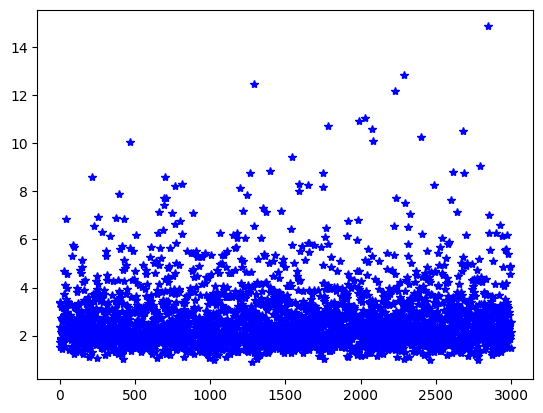

In [33]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.figure()
plt.plot(err_data_new, 'b*')

- The whole error analysis (including all sites and receivers) of the test dataset

In [34]:
from numpy import linalg as LA
reader_test1 = MatReader(TEST_PATH)
x_test1 = reader_test1.read_field('sig')
y_test_rhoxy = reader_test1.read_field('rhoxy').numpy()
y_test_rhoyx = reader_test1.read_field('rhoyx').numpy()
nSample = x_test1.shape[0]

err_all = np.zeros((nSample, 3))
for i in range(nSample):

    xtestNew = x_test1[i,:,:]
    result = predict(xtestNew)
    rhoxy_predict = pow(10, result[:,:,0])
    rhoyx_predict = pow(10, result[:,:,1])

    data1 = y_test_rhoxy[i,::4,:]
    data2 = y_test_rhoyx[i,::4,:]
    data1 = pow(10, data1)
    data2 = pow(10, data2)

    rhoxy_predict_all = rhoxy_predict.flatten()
    rhoyx_predict_all = rhoyx_predict.flatten()

    y_test_rhoxy_all = data1.flatten()
    y_test_rhoyx_all = data2.flatten()
    
    diff1 = (rhoxy_predict_all - y_test_rhoxy_all)/y_test_rhoxy_all*100
    err1 = LA.norm(diff1, 2) / len(y_test_rhoxy_all) ** 0.5

    diff2 = (rhoyx_predict_all - y_test_rhoyx_all)/y_test_rhoyx_all*100
    err2 = LA.norm(diff2, 2) / len(y_test_rhoxy_all) ** 0.5

    diff = np.power(diff1, 2) + np.power(diff2, 2)
    err = np.sqrt(np.sum(diff)) / (2*len(diff)) ** 0.5
    
    err_all[i, 0] = err1
    err_all[i, 1] = err2
    err_all[i, 2] = err

In [35]:
err_data_new = err_all[:,2]
len(err_data_new[err_data_new>5].flatten())

146

In [36]:
# <5% error
nSample - len(err_data_new[err_data_new>5].flatten())

2854

In [37]:
print("error < 5%: ", (1-len(err_data_new[err_data_new>5].flatten())/nSample)*100, "%")

error < 5%:  95.13333333333334 %


In [38]:
# <10% error
nSample - len(err_data_new[err_data_new>10].flatten())

2986

In [39]:
print("error < 10%: ", (1-len(err_data_new[err_data_new>10].flatten())/nSample)*100, "%")

error < 10%:  99.53333333333333 %


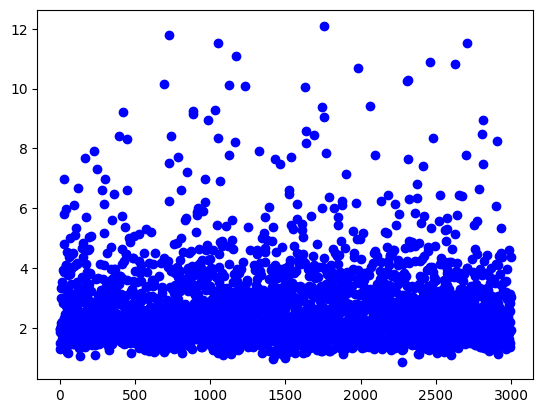

In [40]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.figure()
plt.plot(err_data_new, "bo")